# notebook for getting the reports whose labels are the most valuable
## based on the outputs of robertax50_v0.1

### notes:
score 

attempts to quantify how informative the labels of a particular report is. it (theoretically) lies in the range (0, infty) and a higher score indicates more information gained from labelling a given report.


for v0.2:

    try changing max_len to 512
    
    do actual parameter tuning
    
    tune decision thresholds   
    
    fix special tokens / tokenizer

### loading

In [1]:
PLOT = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer
from simpletransformers.custom_models.models import RobertaForMultiLabelSequenceClassification

import os
import sys
sys.path.append("/home/yz19/")
import xray_yz.utils as xyzu
import xray_yz.functions as xyzf

from tqdm import tqdm

In [2]:
# temporary functions - move these into xyzu
def get_label_index(c, class_list = xyzu.c):
    return np.argwhere(np.array(class_list) == c)[0, 0]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# function for determining boundary of uncertainty
def yashin(labelled_neg, labelled_pos, min_interval = 0.3):
    maxneg = max(labelled_neg)
    minpos = min(labelled_pos)
    
    pos_3std = np.mean(labelled_pos) - 3*np.std(labelled_pos)
    neg_3std = np.mean(labelled_neg) + 3*np.std(labelled_neg)
    
    neg = min(neg_3std, maxneg)
    pos = max(pos_3std, minpos)
    s_score = (pos - neg + 1) / 2

    mid = (pos+neg)/2
    
    if pos > neg:
        neg = mid - min_interval/2
        pos = mid + min_interval/2
        pos = min(0.99, pos)
        neg = max(0.01, neg)
        
    elif neg > pos:
        neg = mid + min_interval/2
        pos = mid - min_interval/2
        neg = min(0.99, neg)
        pos = max(0.01, pos)
        
    else:
        raise Exception("something is very wrong")

    return s_score, neg, pos

In [3]:
# load all reports
all_reports = pd.read_csv("/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/allreports.csv",
                       sep = "$",
                       header = 0,
                       names = ["text", "report_raw", "id"])

all_reports.dropna(inplace = True)
all_reports.sort_values(["id"], inplace = True)
all_reports.drop_duplicates(["text"], inplace = True)
all_reports.reset_index(drop = True, inplace = True)
all_reports = all_reports[["id", "text"]]

In [4]:
# %% loading embeddings

mids = []
logits = []
embeds = []
to_load = sorted(os.listdir("/home/yz19/phd/embeddings/robertax50_v0.1/all_reports_unique"))

for file in to_load:
    # load file into np array a
    a = np.load("/home/yz19/phd/embeddings/robertax50_v0.1/all_reports_unique/{}".format(file), allow_pickle = True)
   
    mids.append(a[:, 0])
    logits.append(a[:, 1])

    for x in a[:, 2]:
        embeds.append(np.squeeze(x))

mids = np.hstack(mids)
logits = np.stack(np.hstack(logits))
embeds = np.array(embeds)
sigmoids = sigmoid(logits)

# sanity check
if not len(all_reports) == len(sigmoids):
    print("something went wrong somewhere")

In [5]:
# load set not excluded
not_excluded = pd.read_csv("/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/allreports_notexcluded.csv",
                       sep = "$",
                       header = 0,
                       names = ["id", "report_raw", "report"])

# load labelled set
PATH_TO_REPORTS_CSV = "/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/yz_multilabel/reports.csv"
PATH_TO_REPORTS_LAB = "/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/yz_multilabel/report_labels.npy"
labelled_reports = pd.read_csv(PATH_TO_REPORTS_CSV, sep = "$", names = ["id", "text"], header = 0)

t = np.stack(np.load(PATH_TO_REPORTS_LAB, allow_pickle = True))
num_samples = np.sum(t, axis = 0)

### get logits for labelled set

In [6]:
# load model and tokenizer
n_labels = 50
max_len = 256
bert_path = xyzu.get_bert_path("robertax")
state_dict = "/home/yz19/phd/finetuned_models/finding_reports_to_label/robertax_50_v0.1_epoch_10.pt"

model = RobertaForMultiLabelSequenceClassification.from_pretrained(bert_path, num_labels = n_labels)
model.load_state_dict(torch.load(state_dict))

tokenizer = RobertaTokenizer.from_pretrained(bert_path, do_lower_case = False)

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): model.cuda()
    
model.eval()

RobertaForMultiLabelSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [7]:
# predict on all of labelled set - would give idea how low & high probabilites are 

batch_size = 200
input_ids, attention_masks = xyzu.doc_to_torch(bert_path, labelled_reports.text.values, max_len, do_lower_case = False)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

predictions = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        logits_temp = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)[0]
        
    predictions.append(logits_temp.data.cpu().numpy())

labelled_predictions = np.vstack(predictions)  

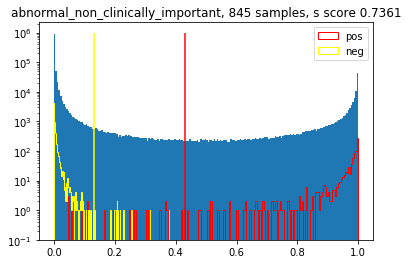

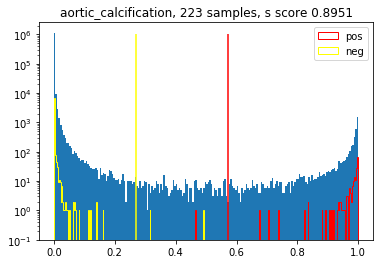

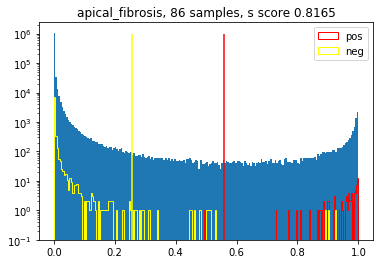

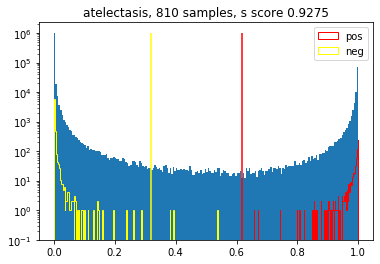

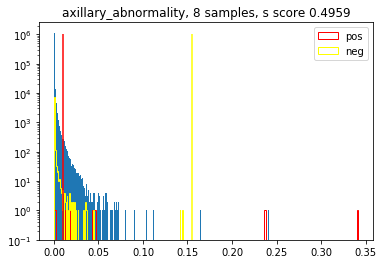

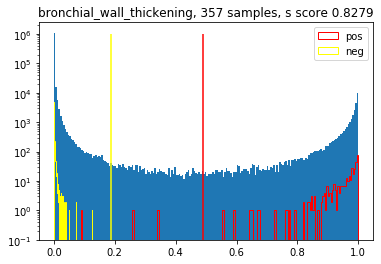

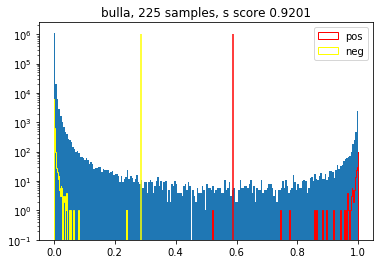

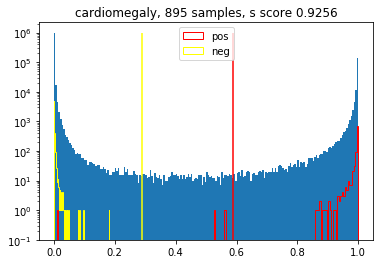

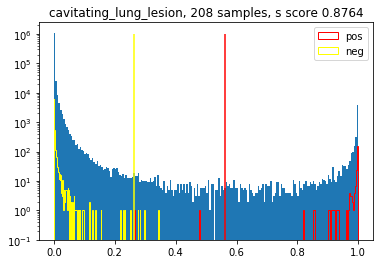

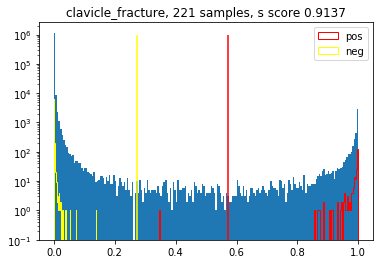

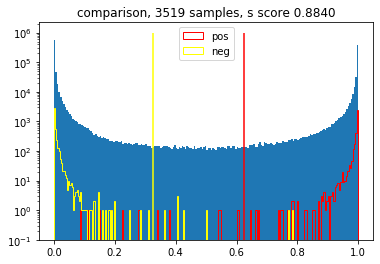

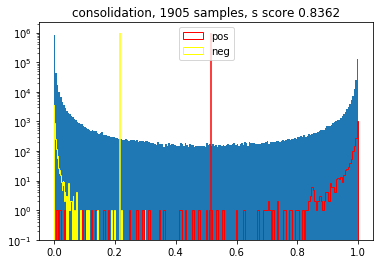

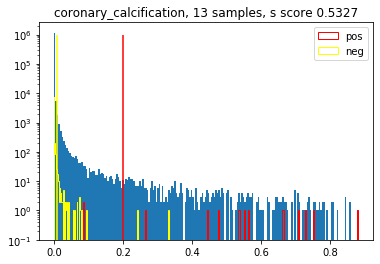

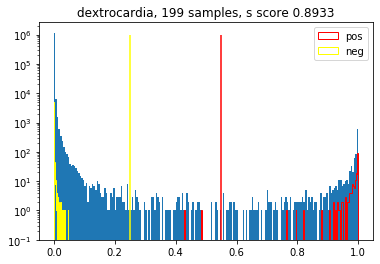

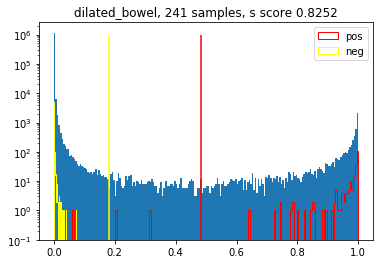

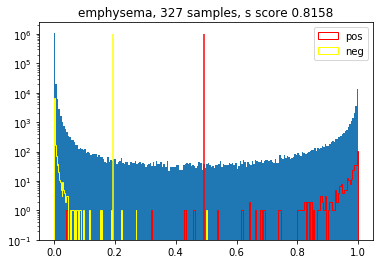

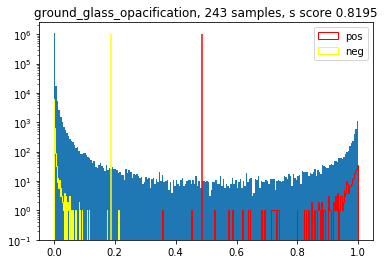

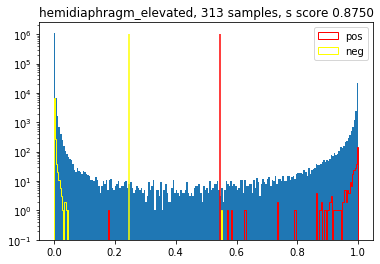

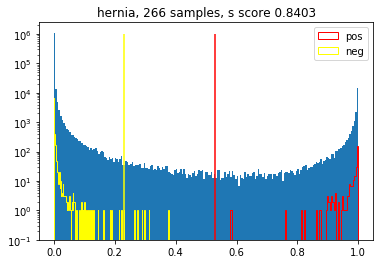

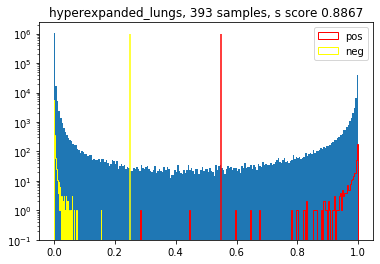

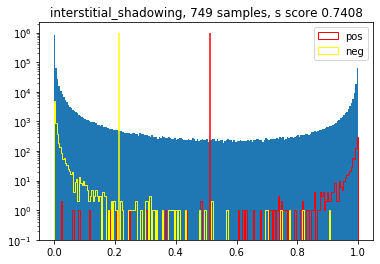

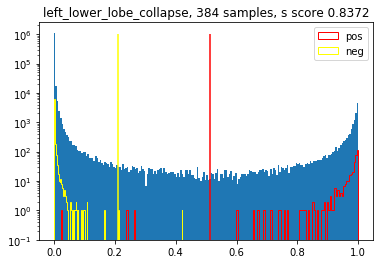

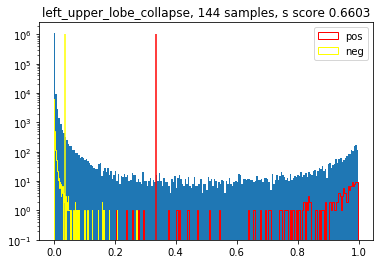

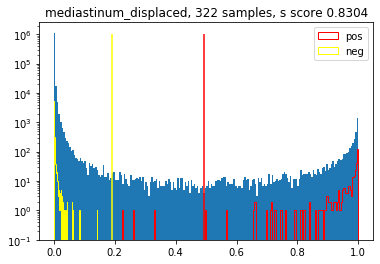

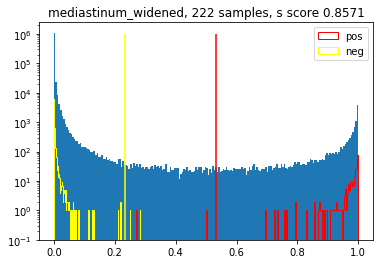

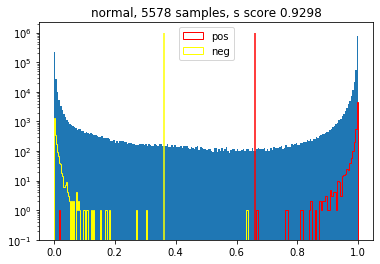

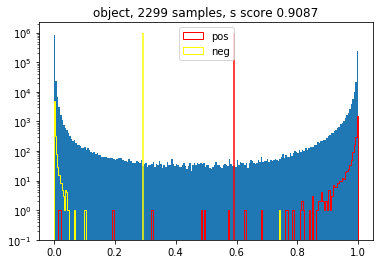

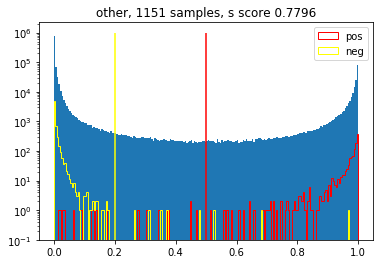

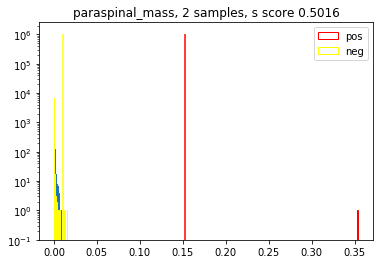

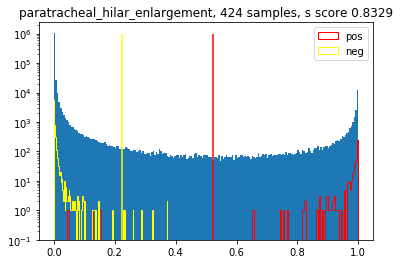

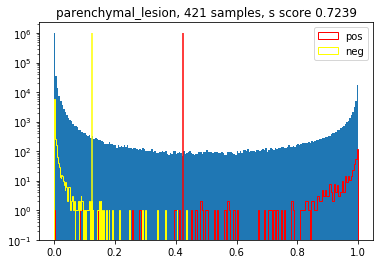

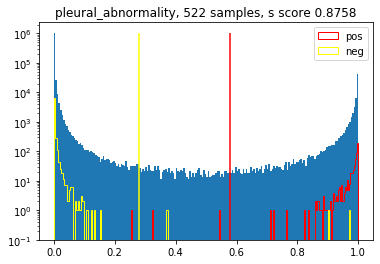

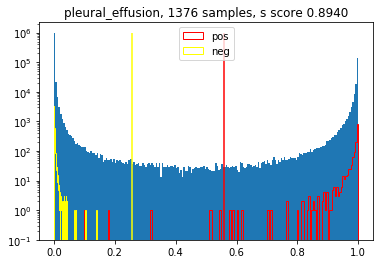

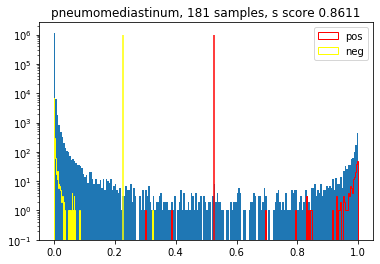

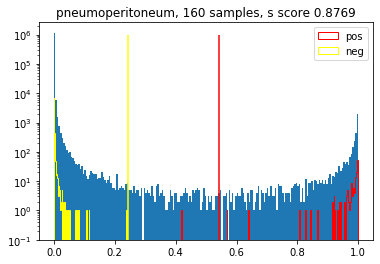

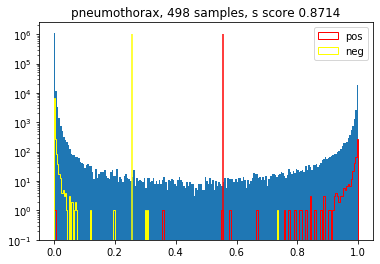

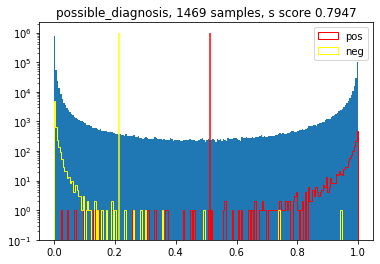

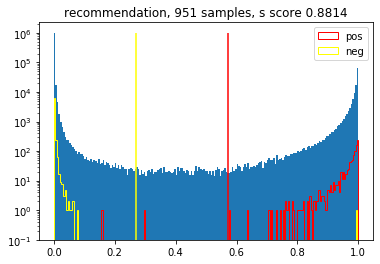

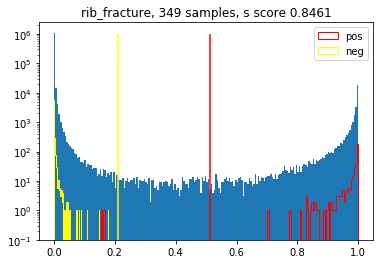

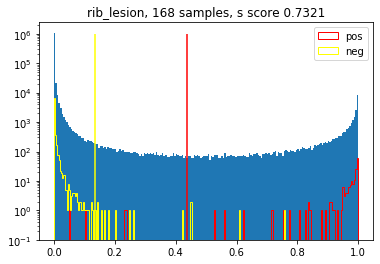

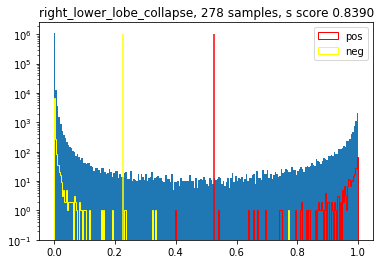

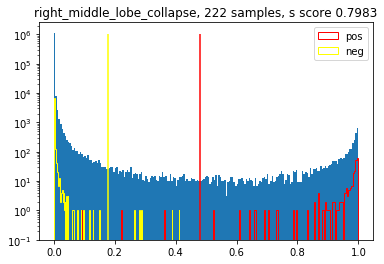

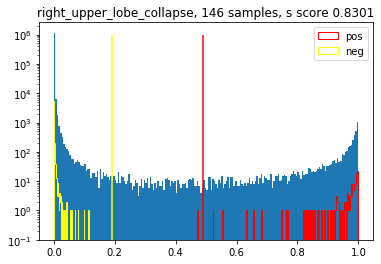

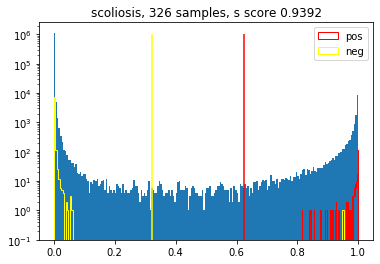

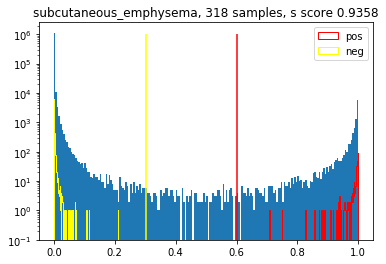

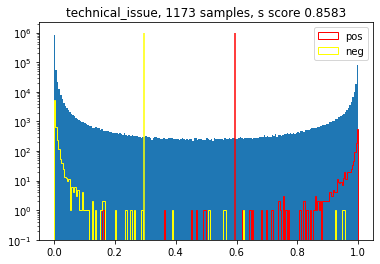

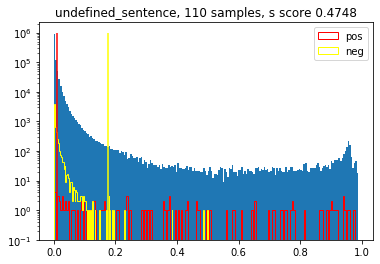

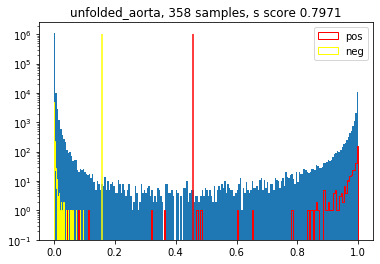

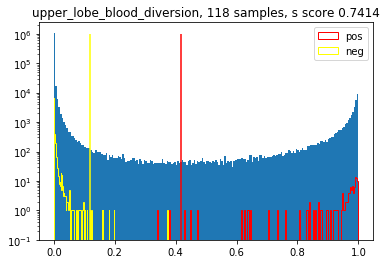

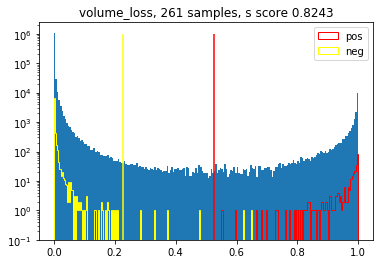

In [8]:
# generate thresholds based on logits and maybe plot
separation_scores = np.zeros((50, 3))

if PLOT:
    plt.rcParams.update({'figure.max_open_warning': 0})
    
for i in range(50):    
    all_data = sigmoid(logits)[:, i]
    labelled_data = sigmoid(labelled_predictions)[:, i]
    labelled_pos = labelled_data[t[:, i] == 1]
    labelled_neg = labelled_data[t[:, i] == 0]
    
    s_score, neg, pos = yashin(labelled_neg, labelled_pos)
    lb = min(pos, neg)
    ub = max(pos, neg)
    
    separation_scores[i, :] = s_score, lb, ub
    
    if PLOT:
        plt.figure()

        y, x, _ = plt.hist(all_data, 200, log = True)

        plt.hist(labelled_pos, 200, log = True, color = "red", histtype = "step", label = "pos")
        plt.hist(labelled_neg, 200, log = True, color = "yellow", histtype = "step", label = "neg")

        plt.vlines(pos, ymin = 0, ymax = 1000000, color = "red")
        plt.vlines(neg, ymin = 0, ymax = 1000000, color = "yellow")

        plt.legend()
        plt.title("{}, {} samples, s score {:.4f}".format(xyzu.c[i], num_samples[i], s_score))

### calculate scores

In [9]:
# housekeeping - keep track of which reports are needed for which labels
needed_for_labels = np.zeros((len(all_reports), 50), dtype = int)

# create column in df to store scores in
all_reports["score"] = np.zeros(len(all_reports))

In [10]:
# actual loop to calculate informativeness of each report
for i in tqdm(range(50)):
    c = xyzu.c[i]
    for j in range(len(all_reports)):
        prob = sigmoids[j, i]
        lb, ub = separation_scores[i, 1:3]
        if (prob < ub) & (prob > lb):
            all_reports.score[j] += separation_scores[i, 0]
            needed_for_labels[j, i] = 1
#             all_reports.loc[j, c] = 1

  0%|          | 0/50 [00:00<?, ?it/s]/home/yz19/anaconda3/envs/nlptest/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 50/50 [03:43<00:00,  4.48s/it]


In [11]:
# integrate needed-ness into main df
for i, c in enumerate(xyzu.c):
    all_reports[c] = needed_for_labels[:, i]

# merge with df for non-excluded reports
not_excluded = not_excluded.merge(all_reports, left_on = "report", right_on = "text")
not_excluded = not_excluded.sort_values("score", ascending = False).drop_duplicates("text")
not_excluded = not_excluded.drop(["report_raw", "id_y", "report"], axis = 1)
not_excluded = not_excluded[~not_excluded.id_x.astype(str).isin(labelled_reports.id.astype(str))]

### calculate stats and save csv

In [12]:
# get top x reports to label
to_label = not_excluded[["id_x", "text", "score"]].sort_values(["score"], ascending = False)[:5000]
to_label.columns = ["id", "text", "score"]

In [13]:
to_label

id                                               text     score
1808877  2245127  Excellent pulmonary artery opacification, no a...  7.196798
1368805  1654634  Prominent vessels and some architectural disto...  6.415917
1344925  1618641  Comparison is made with the previous radiograp...  5.962482
2010818  2601921  Known hyperinflated lung & emphysematous Chang...  5.771894
1044348  1203650  AP semi erect. Increased soft tissue behind th...  5.629850
...          ...                                                ...       ...
1710616  2124308  Mets Salivary Ca Right side Pneumothorax Chest...  2.103150
1251567  1500806  Comparison to previous chest x-ray of 29/05/20...  2.103150
179734      1858  AN ADDENDUM HAS BEEN ENTERED AT THE END OF THI...  2.103150
1979888  2547923  AP erect. RIJ line and drains noted. The pneum...  2.103150
1031420  1187018  No previous chest film at this institution. Th...  2.103150

[5000 rows x 3 columns]

In [14]:
import csv

PATH_TO_CASED_SENTENCES = "/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/annotateX_extractions/20200309-extraction_sentences_cased.csv"

sentences_cased = pd.read_csv(
    PATH_TO_CASED_SENTENCES, 
    names = ["rad", "xray_id", "text", "label"], 
    encoding = "utf-8",
    sep = ",", 
    quoting = csv.QUOTE_NONNUMERIC,
    skiprows=1,
    header = None
)

In [15]:
batch_one = pd.read_csv(
    "/montana-storage02/chest_xrays/data_reports/ReportsForAnnotateX/BERT-based_extractions/RoBERTaX50_v0.1_uncertain_5k.csv", 
    sep = "$",
    encoding = "utf-8"
)

In [16]:
to_label = to_label[~to_label.id.isin(batch_one.id)]

In [17]:
to_label = to_label[~to_label.id.astype(str).isin(labelled_reports.id)]
to_label = to_label[~to_label.id.astype(str).isin(sentences_cased.xray_id)]

In [18]:
to_label = to_label.iloc[:3000]

In [19]:
# finally get stats about chosen reports
stats = sum(not_excluded[not_excluded.id_x.isin(to_label.id)][xyzu.c].values)

for i, c in enumerate(xyzu.c):
    print(c, stats[i])

abnormal_non_clinically_important 791
aortic_calcification 59
apical_fibrosis 264
atelectasis 183
axillary_abnormality 194
bronchial_wall_thickening 96
bulla 56
cardiomegaly 110
cavitating_lung_lesion 62
clavicle_fracture 32
comparison 290
consolidation 475
coronary_calcification 451
dextrocardia 7
dilated_bowel 42
emphysema 206
ground_glass_opacification 39
hemidiaphragm_elevated 33
hernia 50
hyperexpanded_lungs 163
interstitial_shadowing 699
left_lower_lobe_collapse 111
left_upper_lobe_collapse 148
mediastinum_displaced 51
mediastinum_widened 135
normal 237
object 134
other 523
paraspinal_mass 0
paratracheal_hilar_enlargement 368
parenchymal_lesion 395
pleural_abnormality 126
pleural_effusion 144
pneumomediastinum 24
pneumoperitoneum 24
pneumothorax 55
possible_diagnosis 609
recommendation 65
rib_fracture 40
rib_lesion 412
right_lower_lobe_collapse 67
right_middle_lobe_collapse 63
right_upper_lobe_collapse 27
scoliosis 43
subcutaneous_emphysema 21
technical_issue 364
undefined_senten

In [20]:
# # actually save ids
# # not needed since all info is contained in csv instead
# # np.save("aaaaaaaaaaaaaaaaaaaaaaaa5000", to_label.id.values, allow_pickle = True)

# save csv
to_label.to_csv(
    "./RoBERTaX50_v0.1_uncertain_3k_batch2", 
    sep = "$",
    index = False,
    encoding = "utf-8"
)